In [1]:
import tensorflow as tf
import deepchem as dc
import rdkit as rdkit
import rdkit.Chem as Chem
import rdkit.Chem.PandasTools as pt
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('./data/QM9_HAC_5_9_.csv')
reduced_data = list(data['SMILES'])
import random
random.shuffle(reduced_data)
mols = list(filter(lambda x: x is not None, [Chem.MolFromSmiles(x) for x in reduced_data]))
print('how many molecules obtained from smiles: ', len(mols))

how many molecules obtained from smiles:  132432


In [3]:
from feat.molgan_featurizer import MolGanFeaturizer

In [4]:
#create featurizer
feat = MolGanFeaturizer()
#featurize molecules
limited = feat.featurize(mols)
#Remove empty objects
limited = list(filter(lambda x: x is not None, limited))

In [5]:
#create dataset
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in limited],[x.node_features for x in limited])

In [10]:
from models.molgan import MolGAN
from deepchem.models.optimizers import ExponentialDecay
#create model
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))

In [11]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = tf.one_hot(batch[0], gan.edges)
            node_tesor = tf.one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tesor}

In [12]:
#train model
gan.fit_gan(iterbatches(10), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 4999: generator average loss 21.3572, discriminator average loss 979.538
Ending global_step 9999: generator average loss -148.124, discriminator average loss -0.792817
Ending global_step 13239: generator average loss -147.124, discriminator average loss -0.400416
TIMING: model fitting took 213.935 s


1000 molecules generated
465 valid molecules
34 unique molecules


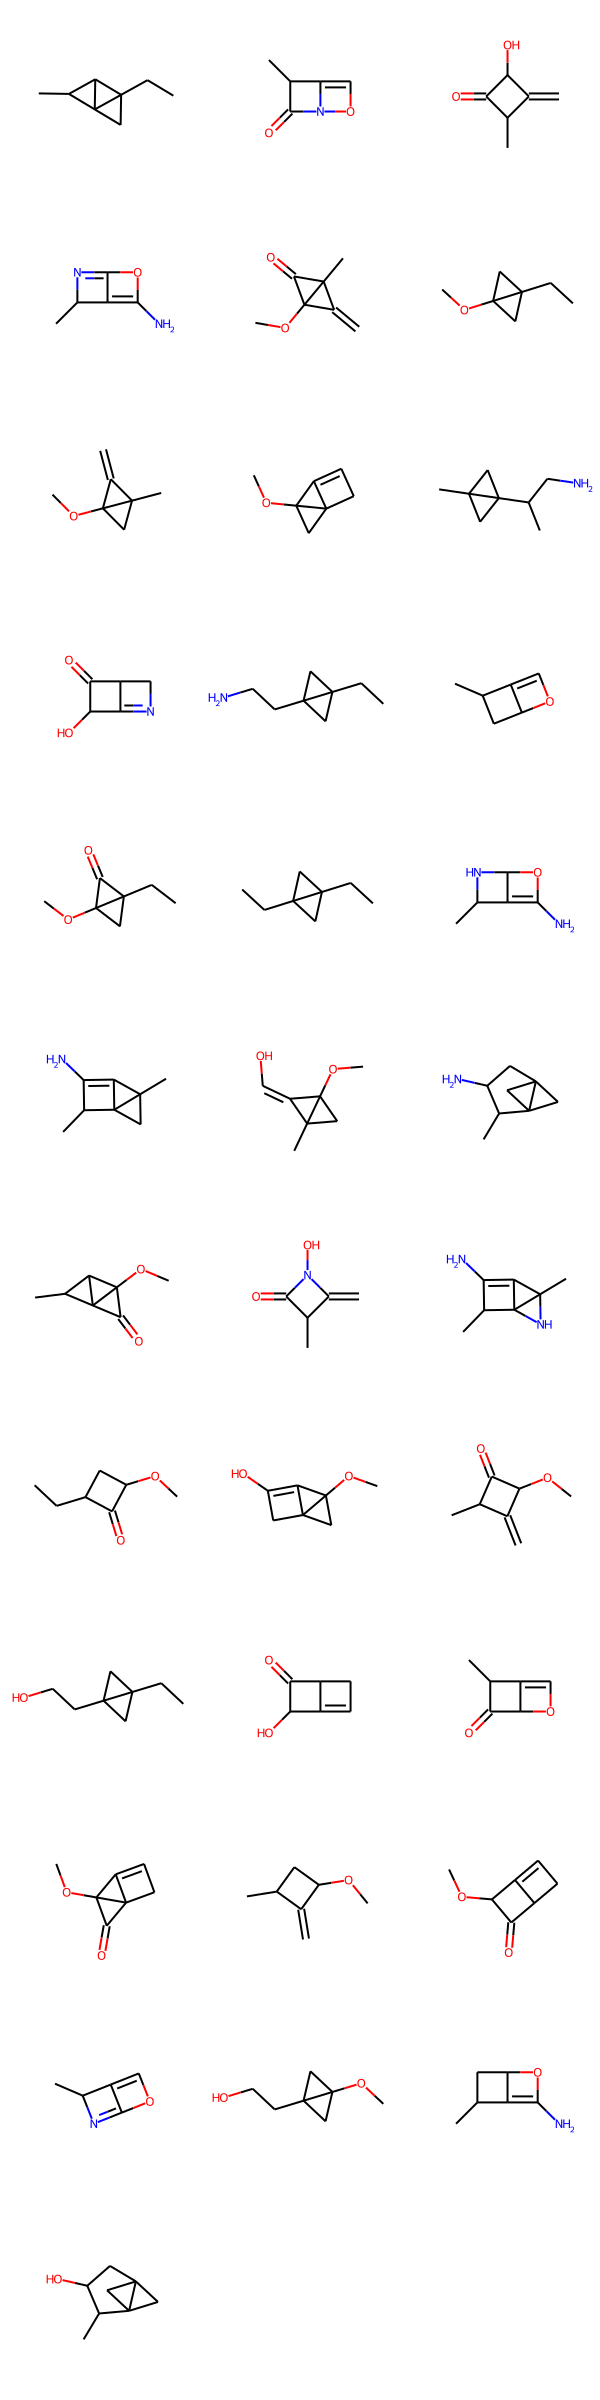

In [13]:
#generat prediced sample
g = gan.predict_gan_generator(1000)

#convert graphs to RDKitmolecules
nmols = feat.defeaturize(g)
print("{} molecules generated".format(len(nmols)))

#remove invalid moles
nmols = list(filter(lambda x: x is not None, nmols))
print ("{} valid molecules".format(len(nmols)))

#get unique molecules
nmols = [Chem.MolFromSmiles(x) for x in list(set([Chem.MolToSmiles(z) for z in nmols]))]
print("{} unique molecules".format(len(nmols)))

#display unique molecules
Chem.Draw.MolsToGridImage(nmols)